In [ ]:
import os
import shutil
import zipfile
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.utils.class_weight import compute_class_weight
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
import tensorflow as tf
gpus = tf.config.list_physical_devices('GPU')

if gpus:
    print("Available GPUs:")
    for gpu in gpus:
        print(f" - {gpu}")
else:
    print("No GPUs detected.")

Available GPUs:
 - PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


In [ ]:
tf.device('/GPU:0')

In [ ]:
# from google.colab import drive
# import zipfile
# import os
# # Mount Google Drive
# drive.mount('/content/drive')

# # Path to the zipped file in your Drive
# zip_path = '/content/drive/My Drive/processed_images.zip'

In [ ]:
# Unzip the file into the desired directory
# output_dir = '/content/unzipped_data'
# os.makedirs(output_dir, exist_ok=True)

# with zipfile.ZipFile(zip_path, 'r') as zip_ref:
#     zip_ref.extractall(output_dir)

# print(f"Files unzipped into: {output_dir}")

In [ ]:
# Constants
RANDOM_SEED = 42
DATASET_DIR = 'unzipped_data/processed_images'
MODEL_SAVE_PATH = 'sample_data/mlp_classifier.hdf5'
TFLITE_SAVE_PATH = 'sample_data/mlp_classifier.tflite'
NUM_CLASSES = 26
TRAIN_DIR = 'unzipped_data/split/train'
VAL_DIR = 'unzipped_data/split/val'
TEST_DIR = 'unzipped_data/split/test'
IMAGE_SIZE = (224,224)
BATCH_SIZE = 128
BUFFER_SIZE = 1000
EPOCHS = 1000

In [ ]:
# Create directories for splits
# os.makedirs(TRAIN_DIR, exist_ok=True)
# os.makedirs(VAL_DIR, exist_ok=True)
# os.makedirs(TEST_DIR, exist_ok=True)

In [ ]:
# Split dataset
# for label in os.listdir(DATASET_DIR):
#     label_dir = os.path.join(DATASET_DIR, label)
#     images = os.listdir(label_dir)

#     # First split: 60% train, 40% temp (val+test)
#     train_imgs, temp_imgs = train_test_split(images, test_size=0.4, random_state=RANDOM_SEED)

#     # Second split: 50% of temp for val, 50% for test
#     val_imgs, test_imgs = train_test_split(temp_imgs, test_size=0.5, random_state=RANDOM_SEED)

#     # Copy images to split directories
#     for split, split_imgs in zip([TRAIN_DIR, VAL_DIR, TEST_DIR], [train_imgs, val_imgs, test_imgs]):
#         split_label_dir = os.path.join(split, label)
#         os.makedirs(split_label_dir, exist_ok=True)
#         for img in split_imgs:
#             shutil.copy(os.path.join(label_dir, img), os.path.join(split_label_dir, img))

In [ ]:
# Load datasets
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    TRAIN_DIR, image_size=IMAGE_SIZE, batch_size=BATCH_SIZE, label_mode='int', shuffle=True, seed=RANDOM_SEED
)
val_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    VAL_DIR, image_size=IMAGE_SIZE, batch_size=BATCH_SIZE, label_mode='int', shuffle=True, seed=RANDOM_SEED
)
test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    TEST_DIR, image_size=IMAGE_SIZE, batch_size=BATCH_SIZE, label_mode='int', shuffle=False
)

Found 140469 files belonging to 26 classes.
Found 46827 files belonging to 26 classes.
Found 46837 files belonging to 26 classes.


In [ ]:
# Prefetch datasets
train_dataset = train_dataset.prefetch(buffer_size=BUFFER_SIZE)
val_dataset = val_dataset.prefetch(buffer_size=BUFFER_SIZE)
test_dataset = test_dataset.prefetch(buffer_size=BUFFER_SIZE)

In [ ]:
# Normalize datasets
def preprocess_image(image, label):
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

In [ ]:
train_dataset = train_dataset.map(preprocess_image)
val_dataset = val_dataset.map(preprocess_image)
test_dataset = test_dataset.map(preprocess_image)

In [ ]:
# Compute class weights
from collections import Counter
label_counts = Counter()
for label in os.listdir(TRAIN_DIR):
    label_counts[label] = len(os.listdir(os.path.join(TRAIN_DIR, label)))

total_samples = sum(label_counts.values())
classes = list(label_counts.keys())  # Classes as strings
samples_per_class = np.array(list(label_counts.values()))

class_weights = total_samples / (len(classes) * samples_per_class)
class_weights_dict = {i: weight for i, weight in enumerate(class_weights)}

print("Class weights:", class_weights_dict)

Class weights: {0: 0.9971675611210495, 1: 1.144387597151842, 2: 0.9498336579032781, 3: 1.003837578252294, 4: 1.0174489352455454, 5: 1.1656211102813046, 6: 0.8814902669528221, 7: 1.0927697908887228, 8: 1.1631116999254782, 9: 1.1148687259913013, 10: 0.9216400283442249, 11: 0.9244787553309114, 12: 0.9725749498026726, 13: 1.0610082180192157, 14: 0.9951471442537937, 15: 0.9927699092528199, 16: 0.8685938659411329, 17: 0.9597892780518469, 18: 0.9407372185536907, 19: 1.0762258657676984, 20: 0.959448383262981, 21: 0.9620110124917817, 22: 1.061842343976778, 23: 1.086178899508212, 24: 0.9194441535319684, 25: 0.9428715263793798}


In [ ]:
# Build the MLP model
def build_mlp_model(input_shape=(224, 224, 3)):
    model = tf.keras.models.Sequential([
        tf.keras.layers.Flatten(input_shape=input_shape),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.4),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.4),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

In [ ]:
# Initialize the model
model = build_mlp_model()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
# Add EarlyStopping to stop training when validation loss stops improving
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=50,  # Stop training if no improvement for 10 epochs
    restore_best_weights=True,  # Restore model weights from the best epoch
    verbose=1
)

In [ ]:
# Train the model with EarlyStopping
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=EPOCHS,
    callbacks=[early_stopping],
    verbose=2
)

Epoch 1/1000
1098/1098 - 66s - 60ms/step - accuracy: 0.7342 - loss: 0.8694 - val_accuracy: 0.9827 - val_loss: 0.0605
Epoch 2/1000
1098/1098 - 51s - 46ms/step - accuracy: 0.9548 - loss: 0.1447 - val_accuracy: 0.9922 - val_loss: 0.0257
Epoch 3/1000
1098/1098 - 50s - 46ms/step - accuracy: 0.9712 - loss: 0.0912 - val_accuracy: 0.9964 - val_loss: 0.0107
Epoch 4/1000
1098/1098 - 50s - 46ms/step - accuracy: 0.9793 - loss: 0.0661 - val_accuracy: 0.9960 - val_loss: 0.0113
Epoch 5/1000
1098/1098 - 51s - 46ms/step - accuracy: 0.9827 - loss: 0.0541 - val_accuracy: 0.9968 - val_loss: 0.0100
Epoch 6/1000
1098/1098 - 50s - 46ms/step - accuracy: 0.9853 - loss: 0.0459 - val_accuracy: 0.9984 - val_loss: 0.0052
Epoch 7/1000
1098/1098 - 50s - 46ms/step - accuracy: 0.9868 - loss: 0.0415 - val_accuracy: 0.9984 - val_loss: 0.0046
Epoch 8/1000
1098/1098 - 50s - 46ms/step - accuracy: 0.9887 - loss: 0.0357 - val_accuracy: 0.9979 - val_loss: 0.0061
Epoch 9/1000
1098/1098 - 50s - 46ms/step - accuracy: 0.9902 - lo

mzdfbkz

In [ ]:
# Display best epoch's validation accuracy and loss
best_val_acc = max(history.history['val_accuracy'])
best_val_loss = min(history.history['val_loss'])
print(f"Best Validation Accuracy: {best_val_acc:.4f}")
print(f"Best Validation Loss: {best_val_loss:.4f}")

Best Validation Accuracy: 0.9999
Best Validation Loss: 0.0003


In [ ]:
# Evaluate the model on the test dataset
test_loss, test_acc = model.evaluate(test_dataset, verbose=2)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_acc}")

366/366 - 13s - 35ms/step - accuracy: 0.9997 - loss: 0.0028
Test Loss: 0.0027815899811685085, Test Accuracy: 0.9997438192367554


In [ ]:
# Evaluate model predictions
y_true_test = np.concatenate([y for _, y in test_dataset], axis=0)
y_pred_test = np.argmax(model.predict(test_dataset), axis=1)

366/366 ━━━━━━━━━━━━━━━━━━━━ 13s 35ms/step


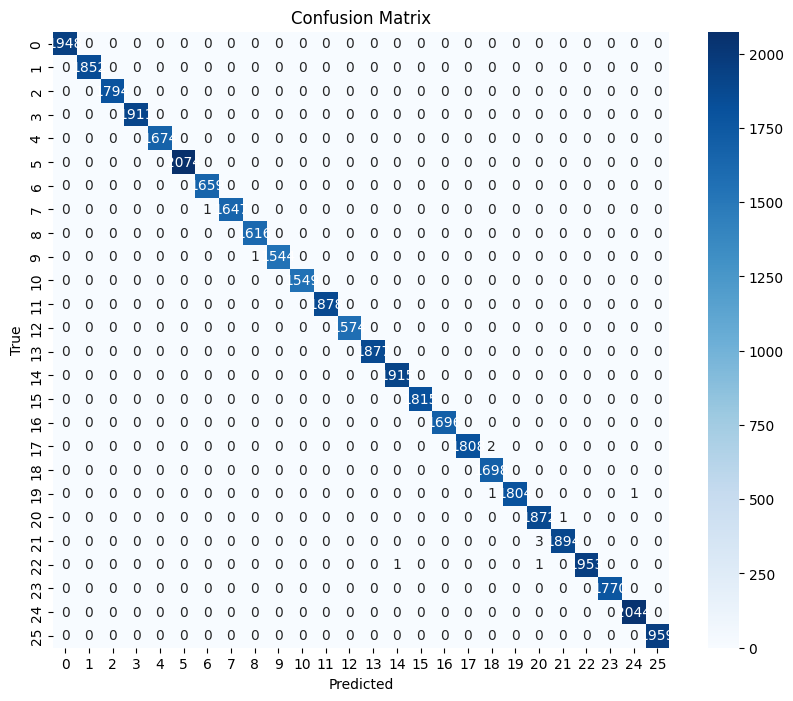

Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1948
           1       1.00      1.00      1.00      1852
           2       1.00      1.00      1.00      1794
           3       1.00      1.00      1.00      1911
           4       1.00      1.00      1.00      1674
           5       1.00      1.00      1.00      2074
           6       1.00      1.00      1.00      1659
           7       1.00      1.00      1.00      1648
           8       1.00      1.00      1.00      1616
           9       1.00      1.00      1.00      1545
          10       1.00      1.00      1.00      1549
          11       1.00      1.00      1.00      1878
          12       1.00      1.00      1.00      1574
          13       1.00      1.00      1.00      1877
          14       1.00      1.00      1.00      1915
          15       1.00      1.00      1.00      1815
          16       1.00      1.00      1.00      1696
     

In [ ]:
# Confusion matrix and classification report
def print_confusion_matrix(y_true, y_pred):
    cmx_data = confusion_matrix(y_true, y_pred)
    df_cmx = pd.DataFrame(cmx_data, index=np.unique(y_true), columns=np.unique(y_true))

    fig, ax = plt.subplots(figsize=(10, 8))
    sns.heatmap(df_cmx, annot=True, fmt='g', square=True, cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

    print('Classification Report')
    print(classification_report(y_true, y_pred))

print_confusion_matrix(y_true_test, y_pred_test)

In [ ]:
# Save the model
model.save(MODEL_SAVE_PATH, include_optimizer=False)

In [ ]:
# Convert the model to TFLite (quantization)
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quantized_model = converter.convert()

Saved artifact at '/tmp/tmpd1w0_anm'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 26), dtype=tf.float32, name=None)
Captures:
  136713866148880: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136713866142896: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136713866147120: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136713866140960: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136715348277584: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136713643428848: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136713866145184: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136713866142016: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136713866146240: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136713866147648: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1367122524612

In [ ]:
# Save the TFLite model
with open(TFLITE_SAVE_PATH, 'wb') as f:
    f.write(tflite_quantized_model)

In [ ]:
# Test TFLite inference
interpreter = tf.lite.Interpreter(model_path=TFLITE_SAVE_PATH)
interpreter.allocate_tensors()

In [ ]:
# Get I/O tensors
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [ ]:
# Run inference
interpreter.invoke()
tflite_results = interpreter.get_tensor(output_details[0]['index'])
print("TFLite Prediction Result:", np.squeeze(tflite_results))
print("TFLite Predicted Class:", np.argmax(np.squeeze(tflite_results)))

TFLite Prediction Result: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan]
TFLite Predicted Class: 0
